<a href="https://colab.research.google.com/github/nzeisenberg/nfl_project/blob/main/NFL_Project_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
### Import statements
import os
import json
import csv
import pandas as pd
import sqlite3 as sql
from collections import namedtuple
import sklearn
import sklearn.linear_model
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import seaborn as sns

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import graphviz

In [ ]:
### Data Entry
teams = pd.read_csv("/content/drive/MyDrive/NFL Project/nfl_teams.csv")
scores = pd.read_csv("/content/drive/MyDrive/NFL Project/spreadspoke_scores_23.csv")
scores = scores[scores["schedule_season"] != 2024]
stats_23 = pd.read_csv("/content/drive/MyDrive/NFL Project/nfl_team_stats_2002-2023.csv")
stats_23["rushing_yards_home"] = stats_23["rush_yards_home"]
stats_23["rushing_yards_away"] = stats_23["rush_yards_away"]
stats_23["passing_yards_home"] = stats_23["pass_yards_home"]
stats_23["passing_yards_away"] = stats_23["pass_yards_away"]
stats_23["turnovers_home"] = stats_23["fumbles_home"] + stats_23["interceptions_home"]
stats_23["turnovers_away"] = stats_23["fumbles_away"] + stats_23["interceptions_away"]
stats = stats_23.dropna(axis=1)


In [ ]:
#Create dictionaries mapping each team to their ID and division
team_dict = teams[["team_name", "team_id"]].set_index('team_name').to_dict()["team_id"]
division_dict = teams[["team_name", "team_division"]].set_index('team_name').to_dict()["team_division"]

In [ ]:
### Creating new columns
win_margin_list = []
winner_list = []
winner_id_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    if current_score["score_home"] > current_score["score_away"]:
        win_margin_list.append(current_score["score_home"] - current_score["score_away"])
        winner_list.append('HOME')
        winner_id_list.append(team_dict[current_score['team_home']])
    elif current_score["score_home"] == current_score["score_away"]:
        win_margin_list.append(current_score["score_home"] - current_score["score_away"])
        winner_list.append('TIE')
        winner_id_list.append("TIE")
    else:
        win_margin_list.append(current_score["score_away"] - current_score["score_home"])
        winner_list.append('AWAY')
        winner_id_list.append(team_dict[current_score['team_away']])

### How much the winner won by
scores["win_margin"] = win_margin_list
### If the winner was home or away
scores['winner'] = winner_list
### ID of the winning team
scores['winner_id'] = winner_id_list

In [ ]:
### Creating boolean column based on if the matchup was between two teams in the same division
division_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    home = current_score["team_home"]
    away = current_score["team_away"]
    if home in division_dict and away in division_dict:
        if division_dict[home] == division_dict[away]:
            division_list.append(True)
        else:
            division_list.append(False)
    else:
        division_list.append(False)
scores["divisional"] = division_list

In [ ]:
### Creating column stating if the favorite is the home or away team
favorite_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    if current_score['team_favorite_id'] == team_dict[current_score['team_home']]:
        favorite_list.append('HOME')
    else:
        favorite_list.append('AWAY')
scores["favorite"] = favorite_list

In [ ]:
### Creating new columns
cover_list = []
cover_margin_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    if current_score['winner'] == current_score['favorite']:
        if current_score['win_margin'] > abs(current_score['spread_favorite']):
            cover_list.append("COVER")
            cover_margin_list.append(current_score['win_margin'] - abs(current_score['spread_favorite']))
        elif current_score['win_margin'] == abs(current_score['spread_favorite']):
            cover_list.append("PUSH")
            cover_margin_list.append(0)
        else:
            cover_list.append("NO COVER")
            cover_margin_list.append(current_score['win_margin'] - abs(current_score['spread_favorite']))
    elif current_score['winner'] == "TIE":
        cover_list.append("NO COVER")
        cover_margin_list.append(current_score['win_margin'] - abs(current_score['spread_favorite']))
    else:
        cover_list.append("UPSET")
        cover_margin_list.append(-current_score['win_margin'] - abs(current_score['spread_favorite']))
### Four options: "COVER", "NO COVER", "PUSH", "UPSET"
scores['result'] = cover_list
### How much the final difered from the spread
# NOTE: Positive if favorite covered, negative if they did not
scores['cover_margin'] = cover_margin_list

In [ ]:
cover_result_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    if current_score['result'] == "COVER" or current_score['result'] == "PUSH":
        cover_result_list.append("COVER")
    else:
        cover_result_list.append("NO COVER")

### Two options: "COVER", "NO COVER"
# NOTE: Pushes are considered as covers
scores['cover'] = cover_result_list

In [ ]:
columns = stats.columns[3:]
###Extracting penalty yards and making that the penalty column

In [ ]:
### Eliminating games from before 2002 (when stats data started)
scores = scores[scores["schedule_season"] >= 2002]

### Creating a dict for each year, mapping each team to a list of each of their statistical outputs by game
### Each team has a list for themselves and for what they allowed to their opponent for each stat
stats_dict = {}
for index, row in stats.iterrows():
    if int(row["date"][-5:-3]) > 2:
        year = int(row["date"][0:4])
    else:
        year = int(row["date"][0:4]) - 1
    if year < 2024:
        if year not in stats_dict:
            stats_dict[year] = {}
            year_d = stats_dict[year]
        if row["home"] not in year_d:
            year_d[row["home"]] = {}
        if row["away"] not in year_d:
            year_d[row["away"]] = {}
        home_dict = year_d[row["home"]]
        away_dict = year_d[row["away"]]
        for column in columns:
            if column[:-5] not in home_dict:
                home_dict[column[:-5]] = []
                home_dict[column[:-5]+"_allowed"] = []
            if column[:-5] not in away_dict:
                away_dict[column[:-5]] = []
                away_dict[column[:-5]+"_allowed"] = []
            if column[-4:] == "home":
                home_dict[column[:-5]].append(row[column])
                away_dict[column[:-5]+"_allowed"].append(row[column])
            else:
                away_dict[column[:-5]].append(row[column])
                home_dict[column[:-5]+"_allowed"].append(row[column])

In [ ]:
### divide any column formatted as a fraction into a float
def div(item):
    try:
        return int(item.split('-')[0])/int(item.split('-')[1])
    except:
        return 0

### convert possession into a float of minutes
def possession(time):
    return int(time[0:2]) + int(time[3:]) / 60

### Gather the mean for every statsitic for each team by year
for year in stats_dict:
    for team in stats_dict[year]:
        for stat in stats_dict[year][team]:
            stat_list = stats_dict[year][team][stat]
            if type(stat_list[0]) == int:
                stats_dict[year][team][stat] = mean(stat_list)
            elif type(stat_list[0]) == str:
                if stat_list[0][2] == ":":
                    stats_dict[year][team][stat] = mean([possession(time) for time in stat_list])
                else:
                    stats_dict[year][team][stat] = mean([div(item) for item in stat_list])



In [ ]:


pre_wc = (scores["schedule_season"] < 2021) & (scores["schedule_week"] == "Wildcard")
pre_d = (scores["schedule_season"] < 2021) & (scores["schedule_week"] == "Division")
pre_c = (scores["schedule_season"] < 2021) & (scores["schedule_week"] == "Conference")
pre_sb = (scores["schedule_season"] < 2021) & (scores["schedule_week"] == "Superbowl")

post_wc = (scores["schedule_season"] >= 2021) & (scores["schedule_week"] == "Wildcard")
post_d = (scores["schedule_season"] >= 2021) & (scores["schedule_week"] == "Division")
post_c = (scores["schedule_season"] >= 2021) & (scores["schedule_week"] == "Conference")
post_sb = (scores["schedule_season"] >= 2021) & (scores["schedule_week"] == "Superbowl")
scores["schedule_week"] = np.where(pre_wc, 18, scores["schedule_week"])
scores["schedule_week"] = np.where(pre_d, 19, scores["schedule_week"])
scores["schedule_week"] = np.where(pre_c, 20, scores["schedule_week"])
scores["schedule_week"] = np.where(pre_sb, 21, scores["schedule_week"])

scores["schedule_week"] = np.where(post_wc, 18, scores["schedule_week"])
scores["schedule_week"] = np.where(post_d, 19, scores["schedule_week"])
scores["schedule_week"] = np.where(post_c, 20, scores["schedule_week"])
scores["schedule_week"] = np.where(post_sb, 21, scores["schedule_week"])


In [ ]:
nfl_teams = [
    "Cardinals",
    "Falcons",
    "Ravens",
    "Bills",
    "Panthers",
    "Bears",
    "Bengals",
    "Browns",
    "Cowboys",
    "Broncos",
    "Lions",
    "Packers",
    "Texans",
    "Colts",
    "Jaguars",
    "Chiefs",
    "Raiders",
    "Chargers",
    "Rams",
    "Dolphins",
    "Vikings",
    "Patriots",
    "Saints",
    "Giants",
    "Jets",
    "Eagles",
    "Steelers",
    "49ers",
    "Seahawks",
    "Buccaneers",
    "Titans",
    "Commanders"
]


def teams_not_playing(df, all_teams):
    result = []
    for year in df['schedule_season'].unique():
        for week in df['schedule_week'].unique():
            teams_played = set(df[(df['schedule_season'] == year) & (df['schedule_week'] == week)]['team_home'].str.split().str[-1]).union(
                set(df[(df['schedule_season'] == year) & (df['schedule_week'] == week)]['team_away'].str.split().str[-1]))
            teams_not_played = set(all_teams) - teams_played
            result.append({'year': year, 'week': week, 'teams_not_playing': list(teams_not_played)})
    return pd.DataFrame(result)


byes_df = teams_not_playing(scores, nfl_teams)
byes = {}
for index, row in byes_df.iterrows():
    year = row["year"]
    if year not in byes:
        byes[year] = {}
    else:
        for team in row["teams_not_playing"]:
            if team not in byes[year]:
                byes[year][team] = []
                byes[year][team] = int(row["week"])
            else:
                continue



In [ ]:
### Add the mean yearly statsitcs of the home and away team for each game played in scores
def apply_stats(df, dic):
    stats_list = []
    for index, row in df.iterrows():
        game_dict = {}
        year = row["schedule_season"]
        home = row["team_home"].split()[-1]
        away = row["team_away"].split()[-1]
        home_stat = dic[year][home]
        away_stat = dic[year][away]
        for stat in home_stat:
            game_dict["home_"+stat] = home_stat[stat]
        for stat in away_stat:
            game_dict["away_"+stat] = away_stat[stat]
        stats_list.append(game_dict)
    return pd.DataFrame(stats_list)


### Accounting for Washington name changes since 2002 (stats_dict considers them Commanders every year)
scores["team_home"] = np.where(scores["team_home"] == "Washington Redskins", "Washington Commanders", scores["team_home"])
scores["team_away"] = np.where(scores["team_away"] == "Washington Redskins", "Washington Commanders", scores["team_away"])
scores["team_home"] = np.where(scores["team_home"] == "Washington Football Team", "Washington Commanders", scores["team_home"])
scores["team_away"] = np.where(scores["team_away"] == "Washington Football Team", "Washington Commanders", scores["team_away"])

In [ ]:
###Formatting
scores = scores.reset_index()
scores = scores.drop(labels = "index", axis = 1)

In [ ]:
### Creating dict where first level is team and second is year instead of stats_dict (which is vice versa)
def team_dict(dct):
    team_dict = {}
    for year in dct:
        for team in dct[year]:
            if team not in team_dict:
                team_dict[team] = {}
            team_dict[team][year] = dct[year][team]
    return team_dict

team_stat_dict = team_dict(stats_dict)

In [ ]:
### Renaming columns in df to reflect favorite and underdog instead of home or away
# If the home team is favored
def home_fav(column):

    if "home" in column:
        return column.replace("home", 'fav')
    elif 'away' in column:
        return column.replace('away', 'ud')
    else:
        return column

# If the away team is favored
def away_fav(column):
    if "home" in column:
        return column.replace("home", 'ud')
    elif 'away' in column:
        return column.replace('away', 'fav')
    else:
        return column

In [ ]:
### Create df with the home and away stats for each gane
stat_df = apply_stats(scores, stats_dict)

In [ ]:
scores

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_humidity,weather_detail,win_margin,winner,winner_id,divisional,favorite,result,cover_margin,cover
0,9/5/2002,2002,1,False,New York Giants,13.0,16.0,San Francisco 49ers,SF,-4.0,...,58.0,NaN,3.0,AWAY,SF,False,AWAY,NO COVER,-1.0,NO COVER
1,9/8/2002,2002,1,False,Buffalo Bills,31.0,37.0,New York Jets,NYJ,-3.0,...,50.0,NaN,6.0,AWAY,NYJ,True,AWAY,COVER,3.0,COVER
2,9/8/2002,2002,1,False,Carolina Panthers,10.0,7.0,Baltimore Ravens,PICK,0.0,...,66.0,NaN,3.0,HOME,CAR,False,AWAY,UPSET,-3.0,NO COVER
3,9/8/2002,2002,1,False,Chicago Bears,27.0,23.0,Minnesota Vikings,CHI,-4.5,...,75.0,NaN,4.0,HOME,CHI,True,HOME,NO COVER,-0.5,NO COVER
4,9/8/2002,2002,1,False,Cincinnati Bengals,6.0,34.0,San Diego Chargers,CIN,-3.0,...,50.0,NaN,28.0,AWAY,LAC,False,HOME,UPSET,-31.0,NO COVER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5924,1/21/2024,2023,19,True,Buffalo Bills,24.0,27.0,Kansas City Chiefs,BUF,-2.5,...,67.0,NaN,3.0,AWAY,KC,False,HOME,UPSET,-5.5,NO COVER
5925,1/21/2024,2023,19,True,Detroit Lions,31.0,23.0,Tampa Bay Buccaneers,DET,-6.0,...,NaN,indoor,8.0,HOME,DET,False,HOME,COVER,2.0,COVER
5926,1/28/2024,2023,20,True,Baltimore Ravens,10.0,17.0,Kansas City Chiefs,BAL,-4.5,...,83.0,NaN,7.0,AWAY,KC,False,HOME,UPSET,-11.5,NO COVER
5927,1/28/2024,2023,20,True,San Francisco 49ers,34.0,31.0,Detroit Lions,SF,-7.5,...,55.0,NaN,3.0,HOME,SF,False,HOME,NO COVER,-4.5,NO COVER


In [ ]:


### Merge stat_df with scores
scores = scores.merge(stat_df, left_index = True, right_index = True)



In [ ]:
### Renaming the columns to identify favorite and underdog instead of home and away
home_favorites = scores[scores["favorite"] == "HOME"]
home_favorites.rename(columns=lambda col: home_fav(col), inplace=True)
away_favorites = scores[scores["favorite"] == "AWAY"]
away_favorites.rename(columns=lambda col: away_fav(col), inplace=True)
scores = pd.concat([home_favorites, away_favorites])
scores = scores.sort_index()
scores

<ipython-input-23-a6a6ac402aa4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_favorites.rename(columns=lambda col: home_fav(col), inplace=True)
<ipython-input-23-a6a6ac402aa4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_favorites.rename(columns=lambda col: away_fav(col), inplace=True)


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_fav,score_fav,score_ud,team_ud,team_favorite_id,spread_favorite,...,ud_def_st_td,ud_def_st_td_allowed,ud_possession,ud_possession_allowed,ud_rushing_yards,ud_rushing_yards_allowed,ud_passing_yards,ud_passing_yards_allowed,ud_turnovers,ud_turnovers_allowed
0,9/5/2002,2002,1,False,San Francisco 49ers,16.0,13.0,New York Giants,SF,-4.0,...,0.235294,0.117647,31.937255,28.660784,117.294118,112.941176,251.647059,204.411765,1.647059,1.588235
1,9/8/2002,2002,1,False,New York Jets,37.0,31.0,Buffalo Bills,NYJ,-3.0,...,0.312500,0.500000,31.328125,29.446875,99.750000,132.625000,249.687500,191.687500,1.937500,1.187500
2,9/8/2002,2002,1,False,Baltimore Ravens,7.0,10.0,Carolina Panthers,PICK,0.0,...,0.375000,0.375000,29.326042,30.673958,99.125000,103.312500,168.375000,187.062500,2.500000,2.062500
3,9/8/2002,2002,1,False,Chicago Bears,27.0,23.0,Minnesota Vikings,CHI,-4.5,...,0.125000,0.687500,31.916667,28.871875,156.687500,104.125000,230.312500,256.437500,2.562500,1.437500
4,9/8/2002,2002,1,False,Cincinnati Bengals,6.0,34.0,San Diego Chargers,CIN,-3.0,...,0.500000,0.187500,31.087500,31.187500,133.562500,108.687500,199.250000,268.437500,1.500000,1.687500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5924,1/21/2024,2023,19,True,Buffalo Bills,24.0,27.0,Kansas City Chiefs,BUF,-2.5,...,0.095238,0.142857,30.905556,29.806349,109.333333,113.047619,248.619048,185.809524,1.523810,1.095238
5925,1/21/2024,2023,19,True,Detroit Lions,31.0,23.0,Tampa Bay Buccaneers,DET,-6.0,...,0.052632,0.000000,29.591228,30.408772,90.368421,93.473684,233.578947,249.631579,1.052632,1.368421
5926,1/28/2024,2023,20,True,Baltimore Ravens,10.0,17.0,Kansas City Chiefs,BAL,-4.5,...,0.095238,0.142857,30.905556,29.806349,109.333333,113.047619,248.619048,185.809524,1.523810,1.095238
5927,1/28/2024,2023,20,True,San Francisco 49ers,34.0,31.0,Detroit Lions,SF,-7.5,...,0.050000,0.150000,31.145000,29.070833,134.300000,91.050000,259.650000,256.950000,1.200000,1.300000


In [ ]:
### Creating shortcut to identifying stats (fav, ud, fav_allowed, ud_allowed)
def stat(stat):
    return ["fav_"+stat, "fav_"+stat+"_allowed", "ud_"+stat, "ud_"+stat+"_allowed"]

In [ ]:
### Creating a list of each team's record against the spread at the point of each game being played
# NOTE: Pushes are considered as covers
def ats(df):
    ats_dict = {}
    ats_fav_list = []
    ats_ud_list = []
    for index, row in df.iterrows():
        fav = row["team_fav"]
        ud = row["team_ud"]
        year = row["schedule_season"]
        if year not in ats_dict:
            ats_dict[year] = {}
        if fav not in ats_dict[year]:
            ats_dict[year][fav] = []
        if ud not in ats_dict[year]:
            ats_dict[year][ud] = []
        if row["cover"] == "COVER":
            ats_dict[year][fav].append(1)
            ats_dict[year][ud].append(0)
        else:
            ats_dict[year][fav].append(0)
            ats_dict[year][ud].append(1)
        if len(ats_dict[year][fav]) == 1:
            ats_fav_list.append(0)
        else:
            ats_fav_list.append(mean(ats_dict[year][fav][:-1]))
        if len(ats_dict[year][ud]) == 1:
            ats_ud_list.append(0)
        else:
            ats_ud_list.append(mean(ats_dict[year][ud][:-1]))
    return pd.DataFrame({"fav_ats": ats_fav_list, "ud_ats": ats_ud_list})

In [ ]:
### Adding the ats statistics to scores
scores = pd.merge(scores, ats(scores), left_index = True, right_index = True)
scores.to_csv('scores.csv')

In [ ]:
def win_pct(df):
    win_pct_dict = {}
    win_pct_fav_list = []
    win_pct_ud_list = []
    win_pct_fav_last_list = []
    win_pct_ud_last_list = []
    for index, row in df.iterrows():
        fav = row["team_fav"].split()[-1]
        ud = row["team_ud"].split()[-1]
        year = row["schedule_season"]
        if year not in win_pct_dict:
            win_pct_dict[year] = {}
        if fav not in win_pct_dict[year]:
            win_pct_dict[year][fav] = []
        if ud not in win_pct_dict[year]:
            win_pct_dict[year][ud] = []
        if row["score_fav"] > row["score_ud"]:
            win_pct_dict[year][fav].append(1)
            win_pct_dict[year][ud].append(0)
        elif row["score_fav"] < row["score_ud"]:
            win_pct_dict[year][fav].append(0)
            win_pct_dict[year][ud].append(1)
        else:
            win_pct_dict[year][fav].append(0.5)
            win_pct_dict[year][ud].append(0.5)
        if len(win_pct_dict[year][fav]) == 1:
            win_pct_fav_list.append(0)
        else:
            win_pct_fav_list.append(mean(win_pct_dict[year][fav][:-1]))
        if len(win_pct_dict[year][ud]) == 1:
            win_pct_ud_list.append(0)
        else:
            win_pct_ud_list.append(mean(win_pct_dict[year][ud][:-1]))
        if year == 2002:
          if len(win_pct_dict[year][fav]) == 1:
            win_pct_fav_last_list.append(0)
          else:
            win_pct_fav_last_list.append(mean(win_pct_dict[year][fav][:-1]))
          if len(win_pct_dict[year][ud]) == 1:
            win_pct_ud_last_list.append(0)
          else:
            win_pct_ud_last_list.append(mean(win_pct_dict[year][ud][:-1]))
        else:
          try:
              win_pct_fav_last_list.append(mean(win_pct_dict[year-1][fav]))
              win_pct_ud_last_list.append(mean(win_pct_dict[year-1][ud]))
          except:
              print(win_pct_dict)
              break
    return pd.DataFrame({"fav_win_pct": win_pct_fav_list, "ud_win_pct": win_pct_ud_list, "fav_win_last_year_pct": win_pct_fav_last_list, "ud_win_last_year_pct": win_pct_ud_last_list})



In [ ]:
scores = pd.merge(scores, win_pct(scores), left_index = True, right_index = True)
scores

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_fav,score_fav,score_ud,team_ud,team_favorite_id,spread_favorite,...,ud_passing_yards,ud_passing_yards_allowed,ud_turnovers,ud_turnovers_allowed,fav_ats,ud_ats,fav_win_pct,ud_win_pct,fav_win_last_year_pct,ud_win_last_year_pct
0,9/5/2002,2002,1,False,San Francisco 49ers,16.0,13.0,New York Giants,SF,-4.0,...,251.647059,204.411765,1.647059,1.588235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9/8/2002,2002,1,False,New York Jets,37.0,31.0,Buffalo Bills,NYJ,-3.0,...,249.687500,191.687500,1.937500,1.187500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,9/8/2002,2002,1,False,Baltimore Ravens,7.0,10.0,Carolina Panthers,PICK,0.0,...,168.375000,187.062500,2.500000,2.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,9/8/2002,2002,1,False,Chicago Bears,27.0,23.0,Minnesota Vikings,CHI,-4.5,...,230.312500,256.437500,2.562500,1.437500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,9/8/2002,2002,1,False,Cincinnati Bengals,6.0,34.0,San Diego Chargers,CIN,-3.0,...,199.250000,268.437500,1.500000,1.687500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5924,1/21/2024,2023,19,True,Buffalo Bills,24.0,27.0,Kansas City Chiefs,BUF,-2.5,...,248.619048,185.809524,1.523810,1.095238,0.444444,0.611111,0.666667,0.666667,0.777778,0.850000
5925,1/21/2024,2023,19,True,Detroit Lions,31.0,23.0,Tampa Bay Buccaneers,DET,-6.0,...,233.578947,249.631579,1.052632,1.368421,0.666667,0.722222,0.722222,0.555556,0.529412,0.444444
5926,1/28/2024,2023,20,True,Baltimore Ravens,10.0,17.0,Kansas City Chiefs,BAL,-4.5,...,248.619048,185.809524,1.523810,1.095238,0.666667,0.631579,0.777778,0.684211,0.555556,0.850000
5927,1/28/2024,2023,20,True,San Francisco 49ers,34.0,31.0,Detroit Lions,SF,-7.5,...,259.650000,256.950000,1.200000,1.300000,0.500000,0.684211,0.722222,0.736842,0.750000,0.529412


In [ ]:
yc = scores["cover"]
yc

,cover
0,NO COVER
1,COVER
2,NO COVER
3,NO COVER
4,NO COVER
...,...
5924,NO COVER
5925,COVER
5926,NO COVER
5927,NO COVER


In [ ]:
X = scores.drop(columns=["cover"])
X["divisional"] = X["divisional"].astype(int)
X["schedule_playoff"] = X["schedule_playoff"].astype(int)
X["favorite"] = X["favorite"].map({"HOME": 1, "AWAY": 0})
y = yc.map({"COVER": 1, "NO COVER": 0})
y

,cover
0,0
1,1
2,0
3,0
4,0
...,...
5924,0
5925,1
5926,0
5927,0


In [ ]:
X = X.loc[:, ["schedule_week", "fav_score", "fav_score_allowed", "ud_score", "ud_score_allowed", "fav_turnovers", "ud_turnovers", "fav_pass_yards", "fav_pass_yards_allowed", "ud_pass_yards", "ud_pass_yards_allowed", "fav_rush_yards", "fav_rush_yards_allowed", "ud_rush_yards", "ud_rush_yards_allowed", "spread_favorite", "fav_ats", "ud_ats", "divisional", "favorite", "schedule_playoff","fav_win_pct", "ud_win_pct" ]]

In [ ]:
categorical = ["divisional", "favorite", "schedule_playoff"]
one_hot_df = pd.DataFrame()
for col in categorical:
    one_hot_df = pd.concat([one_hot_df, pd.get_dummies(X[col], prefix=col, dtype = int)], axis=1)


X = pd.concat([X, one_hot_df], axis = 1).drop(columns=categorical)


In [ ]:
X_unscaled = X
X = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X)
X

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.00,0.506758,0.548725,0.433924,0.319352,0.325831,0.463023,0.423746,0.489869,0.583181,...,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0,1.0,0.0
1,0.00,0.502213,0.400022,0.541952,0.622045,0.301536,0.590032,0.378400,0.432623,0.574591,...,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,1.0,0.0
2,0.00,0.378364,0.488831,0.231164,0.327735,0.617363,0.836013,0.226025,0.489454,0.218109,...,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0,1.0,0.0
3,0.00,0.288886,0.566281,0.570205,0.761454,0.699357,0.863344,0.284491,0.464109,0.489649,...,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,1.0,0.0
4,0.00,0.283773,0.804826,0.423801,0.529105,0.699357,0.398714,0.406295,0.352756,0.353468,...,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5924,0.90,0.659849,0.318278,0.480431,0.234795,0.387206,0.409126,0.503136,0.318248,0.569906,...,0.444444,0.611111,0.666667,0.666667,1.0,0.0,0.0,1.0,0.0,1.0
5925,0.90,0.689236,0.569379,0.440159,0.344367,0.267524,0.203080,0.600724,0.705595,0.503969,...,0.666667,0.722222,0.722222,0.555556,1.0,0.0,0.0,1.0,0.0,1.0
5926,0.95,0.705059,0.193054,0.480431,0.234795,0.249112,0.409126,0.378601,0.280809,0.569906,...,0.666667,0.631579,0.777778,0.684211,1.0,0.0,0.0,1.0,0.0,1.0
5927,0.95,0.738321,0.321539,0.692466,0.569379,0.201929,0.267524,0.592928,0.466934,0.618267,...,0.500000,0.684211,0.722222,0.736842,1.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12)

In [ ]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_unscaled, y, test_size = 0.25, random_state = 12)

,cover
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
5924,NaN
5925,NaN
5926,NaN
5927,NaN


In [ ]:
from sklearn.model_selection import GridSearchCV

rf_grid = MLPClassifier()
gr_space = {
    'activation': ["logistic", "tanh", "relu", "identity"],
    'alpha': [0.01, 0.02, 0.03, 0.04, 0.05],
    'learning_rate_init': [0.001, 0.002, 0.003, 0.004, 0.005]

}

grid = GridSearchCV(rf_grid, gr_space, cv = 3, scoring='accuracy', verbose = 3)
model_grid = grid.fit(X_train, y_train)

print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

MLP_hyp = model_grid.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END activation=logistic, alpha=0.01, learning_rate_init=0.001;, score=0.630 total time=   4.6s
[CV 2/3] END activation=logistic, alpha=0.01, learning_rate_init=0.001;, score=0.636 total time=   5.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, alpha=0.01, learning_rate_init=0.001;, score=0.641 total time=   7.3s
[CV 1/3] END activation=logistic, alpha=0.01, learning_rate_init=0.002;, score=0.632 total time=   3.9s
[CV 2/3] END activation=logistic, alpha=0.01, learning_rate_init=0.002;, score=0.649 total time=   9.3s
[CV 3/3] END activation=logistic, alpha=0.01, learning_rate_init=0.002;, score=0.651 total time=   4.4s
[CV 1/3] END activation=logistic, alpha=0.01, learning_rate_init=0.003;, score=0.634 total time=   2.4s
[CV 2/3] END activation=logistic, alpha=0.01, learning_rate_init=0.003;, score=0.640 total time=   3.1s
[CV 3/3] END activation=logistic, alpha=0.01, learning_rate_init=0.003;, score=0.646 total time=   5.6s
[CV 1/3] END activation=logistic, alpha=0.01, learning_rate_init=0.004;, score=0.640 total time=   2.6s
[CV 2/3] END activation=logistic, alpha=0.01, learning_rate_init=0.004;, score=0.640 total time=   2.9s
[CV 3/3] END activation=logistic, alpha=0.01, learning_rate_init

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, alpha=0.02, learning_rate_init=0.001;, score=0.636 total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, alpha=0.02, learning_rate_init=0.001;, score=0.642 total time=   4.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, alpha=0.02, learning_rate_init=0.001;, score=0.640 total time=   8.4s
[CV 1/3] END activation=logistic, alpha=0.02, learning_rate_init=0.002;, score=0.638 total time=   3.5s
[CV 2/3] END activation=logistic, alpha=0.02, learning_rate_init=0.002;, score=0.648 total time=   3.2s
[CV 3/3] END activation=logistic, alpha=0.02, learning_rate_init=0.002;, score=0.642 total time=   5.9s
[CV 1/3] END activation=logistic, alpha=0.02, learning_rate_init=0.003;, score=0.635 total time=   4.2s
[CV 2/3] END activation=logistic, alpha=0.02, learning_rate_init=0.003;, score=0.637 total time=   1.7s
[CV 3/3] END activation=logistic, alpha=0.02, learning_rate_init=0.003;, score=0.640 total time=   4.3s
[CV 1/3] END activation=logistic, alpha=0.02, learning_rate_init=0.004;, score=0.639 total time=   2.5s
[CV 2/3] END activation=logistic, alpha=0.02, learning_rate_init=0.004;, score=0.655 total time=   5.3s
[CV 3/3] END activation=logistic, alpha=0.02, learning_rate_init

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, alpha=0.03, learning_rate_init=0.001;, score=0.630 total time=   6.7s
[CV 2/3] END activation=logistic, alpha=0.03, learning_rate_init=0.001;, score=0.640 total time=   5.0s
[CV 3/3] END activation=logistic, alpha=0.03, learning_rate_init=0.001;, score=0.642 total time=   3.5s
[CV 1/3] END activation=logistic, alpha=0.03, learning_rate_init=0.002;, score=0.634 total time=   2.2s
[CV 2/3] END activation=logistic, alpha=0.03, learning_rate_init=0.002;, score=0.647 total time=   5.3s
[CV 3/3] END activation=logistic, alpha=0.03, learning_rate_init=0.002;, score=0.646 total time=   4.2s
[CV 1/3] END activation=logistic, alpha=0.03, learning_rate_init=0.003;, score=0.632 total time=   2.4s
[CV 2/3] END activation=logistic, alpha=0.03, learning_rate_init=0.003;, score=0.632 total time=   2.6s
[CV 3/3] END activation=logistic, alpha=0.03, learning_rate_init=0.003;, score=0.638 total time=   2.4s
[CV 1/3] END activation=logistic, alpha=0.03, learning_rate_init

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, alpha=0.04, learning_rate_init=0.001;, score=0.644 total time=   4.6s
[CV 1/3] END activation=logistic, alpha=0.04, learning_rate_init=0.002;, score=0.632 total time=   6.9s
[CV 2/3] END activation=logistic, alpha=0.04, learning_rate_init=0.002;, score=0.642 total time=   6.8s
[CV 3/3] END activation=logistic, alpha=0.04, learning_rate_init=0.002;, score=0.648 total time=   3.2s
[CV 1/3] END activation=logistic, alpha=0.04, learning_rate_init=0.003;, score=0.628 total time=   2.5s
[CV 2/3] END activation=logistic, alpha=0.04, learning_rate_init=0.003;, score=0.651 total time=   3.6s
[CV 3/3] END activation=logistic, alpha=0.04, learning_rate_init=0.003;, score=0.652 total time=   4.3s
[CV 1/3] END activation=logistic, alpha=0.04, learning_rate_init=0.004;, score=0.626 total time=   2.6s
[CV 2/3] END activation=logistic, alpha=0.04, learning_rate_init=0.004;, score=0.625 total time=   2.1s
[CV 3/3] END activation=logistic, alpha=0.04, learning_rate_init

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, alpha=0.05, learning_rate_init=0.001;, score=0.633 total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, alpha=0.05, learning_rate_init=0.001;, score=0.636 total time=   4.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, alpha=0.05, learning_rate_init=0.001;, score=0.640 total time=   7.9s
[CV 1/3] END activation=logistic, alpha=0.05, learning_rate_init=0.002;, score=0.636 total time=   3.8s
[CV 2/3] END activation=logistic, alpha=0.05, learning_rate_init=0.002;, score=0.641 total time=   3.6s
[CV 3/3] END activation=logistic, alpha=0.05, learning_rate_init=0.002;, score=0.650 total time=   3.1s
[CV 1/3] END activation=logistic, alpha=0.05, learning_rate_init=0.003;, score=0.640 total time=   7.0s
[CV 2/3] END activation=logistic, alpha=0.05, learning_rate_init=0.003;, score=0.641 total time=   3.1s
[CV 3/3] END activation=logistic, alpha=0.05, learning_rate_init=0.003;, score=0.659 total time=   3.0s
[CV 1/3] END activation=logistic, alpha=0.05, learning_rate_init=0.004;, score=0.635 total time=   2.7s
[CV 2/3] END activation=logistic, alpha=0.05, learning_rate_init=0.004;, score=0.647 total time=   3.4s
[CV 3/3] END activation=logistic, alpha=0.05, learning_rate_init

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.01, learning_rate_init=0.001;, score=0.638 total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.01, learning_rate_init=0.001;, score=0.636 total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.01, learning_rate_init=0.001;, score=0.647 total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.01, learning_rate_init=0.002;, score=0.623 total time=   6.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.01, learning_rate_init=0.002;, score=0.626 total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.01, learning_rate_init=0.002;, score=0.651 total time=   3.7s
[CV 1/3] END activation=relu, alpha=0.01, learning_rate_init=0.003;, score=0.628 total time=   5.5s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.01, learning_rate_init=0.003;, score=0.634 total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.01, learning_rate_init=0.003;, score=0.633 total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.01, learning_rate_init=0.004;, score=0.610 total time=   4.5s
[CV 2/3] END activation=relu, alpha=0.01, learning_rate_init=0.004;, score=0.607 total time=   5.9s
[CV 3/3] END activation=relu, alpha=0.01, learning_rate_init=0.004;, score=0.628 total time=   3.0s
[CV 1/3] END activation=relu, alpha=0.01, learning_rate_init=0.005;, score=0.622 total time=   2.7s
[CV 2/3] END activation=relu, alpha=0.01, learning_rate_init=0.005;, score=0.623 total time=   3.4s
[CV 3/3] END activation=relu, alpha=0.01, learning_rate_init=0.005;, score=0.652 total time=   4.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.02, learning_rate_init=0.001;, score=0.619 total time=   3.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.02, learning_rate_init=0.001;, score=0.657 total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.02, learning_rate_init=0.001;, score=0.651 total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.02, learning_rate_init=0.002;, score=0.616 total time=   6.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.02, learning_rate_init=0.002;, score=0.633 total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.02, learning_rate_init=0.002;, score=0.652 total time=   3.8s
[CV 1/3] END activation=relu, alpha=0.02, learning_rate_init=0.003;, score=0.628 total time=   3.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.02, learning_rate_init=0.003;, score=0.638 total time=   8.3s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.02, learning_rate_init=0.003;, score=0.620 total time=   3.6s
[CV 1/3] END activation=relu, alpha=0.02, learning_rate_init=0.004;, score=0.607 total time=   7.0s
[CV 2/3] END activation=relu, alpha=0.02, learning_rate_init=0.004;, score=0.636 total time=   3.4s
[CV 3/3] END activation=relu, alpha=0.02, learning_rate_init=0.004;, score=0.644 total time=   2.0s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.02, learning_rate_init=0.005;, score=0.607 total time=   3.6s
[CV 2/3] END activation=relu, alpha=0.02, learning_rate_init=0.005;, score=0.627 total time=   5.9s
[CV 3/3] END activation=relu, alpha=0.02, learning_rate_init=0.005;, score=0.655 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.03, learning_rate_init=0.001;, score=0.626 total time=   3.8s
[CV 2/3] END activation=relu, alpha=0.03, learning_rate_init=0.001;, score=0.662 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.03, learning_rate_init=0.001;, score=0.652 total time=   7.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.03, learning_rate_init=0.002;, score=0.625 total time=   3.8s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.03, learning_rate_init=0.002;, score=0.643 total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.03, learning_rate_init=0.002;, score=0.638 total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.03, learning_rate_init=0.003;, score=0.623 total time=   5.5s
[CV 2/3] END activation=relu, alpha=0.03, learning_rate_init=0.003;, score=0.642 total time=   2.3s
[CV 3/3] END activation=relu, alpha=0.03, learning_rate_init=0.003;, score=0.647 total time=   1.0s
[CV 1/3] END activation=relu, alpha=0.03, learning_rate_init=0.004;, score=0.622 total time=   2.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.03, learning_rate_init=0.004;, score=0.638 total time=   6.3s
[CV 3/3] END activation=relu, alpha=0.03, learning_rate_init=0.004;, score=0.651 total time=   1.9s
[CV 1/3] END activation=relu, alpha=0.03, learning_rate_init=0.005;, score=0.626 total time=   2.4s
[CV 2/3] END activation=relu, alpha=0.03, learning_rate_init=0.005;, score=0.646 total time=   1.1s
[CV 3/3] END activation=relu, alpha=0.03, learning_rate_init=0.005;, score=0.640 total time=   3.1s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.04, learning_rate_init=0.001;, score=0.628 total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.04, learning_rate_init=0.001;, score=0.644 total time=   5.6s
[CV 3/3] END activation=relu, alpha=0.04, learning_rate_init=0.001;, score=0.657 total time=   3.1s
[CV 1/3] END activation=relu, alpha=0.04, learning_rate_init=0.002;, score=0.634 total time=   2.9s
[CV 2/3] END activation=relu, alpha=0.04, learning_rate_init=0.002;, score=0.621 total time=   5.7s
[CV 3/3] END activation=relu, alpha=0.04, learning_rate_init=0.002;, score=0.651 total time=   2.7s
[CV 1/3] END activation=relu, alpha=0.04, learning_rate_init=0.003;, score=0.624 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.04, learning_rate_init=0.003;, score=0.639 total time=   3.8s
[CV 3/3] END activation=relu, alpha=0.04, learning_rate_init=0.003;, score=0.652 total time=   1.9s
[CV 1/3] END activation=relu, alpha=0.04, learning_rate_init=0.004;, score=0.610 total time=   4.3s
[CV 2/3] END activation=relu, alpha=0.04, learning_rate_init=0.004;, score=0.632 total time=   5.1s
[CV 3/3] END activation=relu, alpha=0.04, learning_rate_init=0.004;, score=0.641 total time=   3.1s
[CV 1/3] END activation=relu, alpha=0.04, learning_rate_init=0.005;, score=0.615 total time=   2.0s
[CV 2/3] END activation=relu, alpha=0.04, learning_rate_init=0.005;, score=0.615 total time=   2.3s
[CV 3/3] END activation=relu, alpha=0.04, learning_rate_init=0.005;, score=0.646 total time=   3.9s
[CV 1/3] END activation=relu, alpha=0.05, learning_rate_init=0.001;, score=0.629 total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.05, learning_rate_init=0.001;, score=0.638 total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.05, learning_rate_init=0.001;, score=0.646 total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, alpha=0.05, learning_rate_init=0.002;, score=0.619 total time=   6.9s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, alpha=0.05, learning_rate_init=0.002;, score=0.640 total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, alpha=0.05, learning_rate_init=0.002;, score=0.661 total time=   3.6s
[CV 1/3] END activation=relu, alpha=0.05, learning_rate_init=0.003;, score=0.623 total time=   5.1s
[CV 2/3] END activation=relu, alpha=0.05, learning_rate_init=0.003;, score=0.649 total time=   3.8s
[CV 3/3] END activation=relu, alpha=0.05, learning_rate_init=0.003;, score=0.648 total time=   3.4s
[CV 1/3] END activation=relu, alpha=0.05, learning_rate_init=0.004;, score=0.615 total time=   2.9s
[CV 2/3] END activation=relu, alpha=0.05, learning_rate_init=0.004;, score=0.632 total time=   4.9s
[CV 3/3] END activation=relu, alpha=0.05, learning_rate_init=0.004;, score=0.639 total time=   2.1s
[CV 1/3] END activation=relu, alpha=0.05, learning_rate_init=0.005;, score=0.634 total time=   2.0s
[CV 2/3] END activation=relu, alpha=0.05, learning_rate_init=0.005;, score=0.611 total time=   2.6s
[CV 3/3] END activation=relu, alpha=0.05, learning_rate_init=0.005;, score=0.647 total time=   2.9s


In [ ]:
from sklearn.model_selection import GridSearchCV

rf_grid = RandomForestClassifier()
gr_space = {
    'max_depth': [6,7,8],
    'n_estimators': [180, 190, 200, 210, 220,]

}

grid = GridSearchCV(rf_grid, gr_space, cv = 3, scoring='accuracy', verbose = 3)
model_grid = grid.fit(X_train, y_train)

print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

RF_hyp = model_grid.best_params_

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END .....max_depth=6, n_estimators=180;, score=0.607 total time=   1.2s
[CV 2/3] END .....max_depth=6, n_estimators=180;, score=0.610 total time=   1.1s
[CV 3/3] END .....max_depth=6, n_estimators=180;, score=0.629 total time=   1.1s
[CV 1/3] END .....max_depth=6, n_estimators=190;, score=0.615 total time=   1.2s
[CV 2/3] END .....max_depth=6, n_estimators=190;, score=0.601 total time=   1.5s
[CV 3/3] END .....max_depth=6, n_estimators=190;, score=0.631 total time=   1.7s
[CV 1/3] END .....max_depth=6, n_estimators=200;, score=0.599 total time=   1.9s
[CV 2/3] END .....max_depth=6, n_estimators=200;, score=0.607 total time=   1.4s
[CV 3/3] END .....max_depth=6, n_estimators=200;, score=0.632 total time=   1.3s
[CV 1/3] END .....max_depth=6, n_estimators=210;, score=0.607 total time=   1.3s
[CV 2/3] END .....max_depth=6, n_estimators=210;, score=0.605 total time=   1.3s
[CV 3/3] END .....max_depth=6, n_estimators=210;

In [ ]:
svm_grid = SVC()
gr_space = {
    'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']

}

grid = GridSearchCV(svm_grid, gr_space, cv = 3, scoring='accuracy', verbose = 3)
model_grid = grid.fit(X_train, y_train)

print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

SVC_hyp = model_grid.best_params_

In [ ]:
models = []
models.append((LogisticRegression(
    random_state = 12, max_iter=50
                                  ), "Logistic Regression"))
models.append((SVC(C = SVC_hyp["C"]  ,
                  gamma = SVC_hyp["gamma"],
                  kernel = SVC_hyp["kernel"],
                  random_state = 12,
                  probability = True), "SVM")),


models.append((MLPClassifier(alpha = MLP_hyp["alpha"],
                                learning_rate_init = MLP_hyp["learning_rate_init"],
                                activation = MLP_hyp["activation"],
                              random_state = 12), "MLP"))
models.append((RandomForestClassifier(
                    max_depth = RF_hyp["max_depth"],
                    n_estimators = RF_hyp["n_estimators"],
                    random_state = 12), "Random Forest"))

models

[(LogisticRegression(max_iter=50, random_state=12), 'Logistic Regression'),
 (SVC(C=1000, gamma=0.01, probability=True, random_state=12), 'SVM'),
 (MLPClassifier(activation='tanh', alpha=0.02, random_state=12), 'MLP'),
 (RandomForestClassifier(max_depth=6, n_estimators=190, random_state=12),
  'Random Forest')]

In [ ]:
results = {}
for model, n in models:
   kfold = model_selection.KFold(n_splits=10)
   cv =  model_selection.cross_val_score(model, X_train, y_train, cv = kfold, scoring = "accuracy")
   results.update({n: cv.mean()})

results

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'Logistic Regression': 0.6448547423828324,
 'SVM': 0.6477796335661504,
 'MLP': 0.6345055167527078,
 'Random Forest': 0.6066271889867395}

In [ ]:
prediction_df = pd.DataFrame()
for model, n in models:
  model.fit(X_train, y_train)
  prediction_df[n] = model.predict(X_test)
  prediction_df[n + "_proba"] = model.predict_proba(X_test)[:,1]

prediction_df

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Logistic Regression,Logistic Regression_proba,SVM,SVM_proba,MLP,MLP_proba,Random Forest,Random Forest_proba
0,0,0.256471,0,0.198503,0,0.221656,1,0.500616
1,1,0.625859,1,0.695861,1,0.624651,1,0.570440
2,1,0.742754,1,0.726910,1,0.741537,1,0.626537
3,0,0.378343,0,0.427771,0,0.362143,1,0.572910
4,0,0.304198,0,0.182659,0,0.274518,0,0.404079
...,...,...,...,...,...,...,...,...
1478,1,0.582683,1,0.525228,1,0.572040,1,0.571070
1479,1,0.540325,1,0.569572,1,0.531633,0,0.465365
1480,1,0.535378,0,0.500000,1,0.532168,1,0.540879
1481,1,0.588943,1,0.593979,1,0.599287,0,0.486268


In [ ]:
prediction_df["actual"] = y_test.reset_index(drop=True)

prediction_df["cover_prediction"] = prediction_df[["Logistic Regression", "SVM", "MLP", "Random Forest"]].mean(axis=1)

prediction_df["cover_prediction_proba"] = prediction_df[["Logistic Regression_proba", "SVM_proba", "MLP_proba", "Random Forest_proba"]].mean(axis=1)
prediction_df

,Logistic Regression,Logistic Regression_proba,SVM,SVM_proba,MLP,MLP_proba,Random Forest,Random Forest_proba,actual,cover_prediction,cover_prediction_proba
0,0,0.256471,0,0.198503,0,0.221656,1,0.500616,0,0.25,0.294311
1,1,0.625859,1,0.695861,1,0.624651,1,0.570440,1,1.00,0.629203
2,1,0.742754,1,0.726910,1,0.741537,1,0.626537,1,1.00,0.709434
3,0,0.378343,0,0.427771,0,0.362143,1,0.572910,1,0.25,0.435292
4,0,0.304198,0,0.182659,0,0.274518,0,0.404079,0,0.00,0.291363
...,...,...,...,...,...,...,...,...,...,...,...
1478,1,0.582683,1,0.525228,1,0.572040,1,0.571070,1,1.00,0.562755
1479,1,0.540325,1,0.569572,1,0.531633,0,0.465365,0,0.75,0.526724
1480,1,0.535378,0,0.500000,1,0.532168,1,0.540879,0,0.75,0.527106
1481,1,0.588943,1,0.593979,1,0.599287,0,0.486268,1,0.75,0.567119


In [ ]:
X_test_u = X_test_u.reset_index(drop = True)

X_test_u["prediction"] =  prediction_df["cover_prediction"]
X_test_u["prediction_proba"] = prediction_df["cover_prediction_proba"]
X_test_u["actual"] = y_test.reset_index(drop = True)


<ipython-input-198-8d8602f8d02d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_filt["prediction"] =  round(X_test_u["prediction_proba"])


<Axes: >

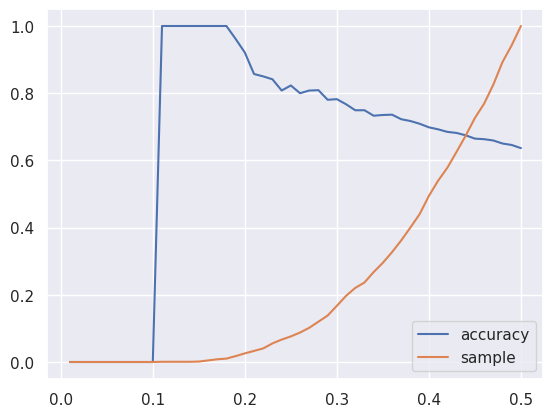

In [198]:
conf_df = pd.DataFrame()
test_rows = X_test_u.shape[0]
for i in np.linspace(0.01, 0.50, 50):
  X_filt = X_test_u[(X_test_u["prediction_proba"] < i) | (X_test_u["prediction_proba"] > (1-i))]
  filt_rows = X_filt.shape[0]
  X_filt["prediction"] =  round(X_test_u["prediction_proba"])
  X_accurate = X_filt[X_filt["prediction"] == X_filt["actual"]]
  accurate_rows = X_accurate.shape[0]
  try:
    conf_df.loc[i, "accuracy"] = accurate_rows / filt_rows
  except:
    conf_df.loc[i, "accuracy"] = 0
  conf_df.loc[i, "sample"] = filt_rows / test_rows




conf_df.plot()

In [ ]:
cutoff_accuracy = conf_df[(conf_df["accuracy"] > 0.70) &  (conf_df["sample"] > 0.2)].index[0]
cutoff_accuracy

0.32

<ipython-input-77-7b8b269af134>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_u_confident["prediction"] =  round(X_test_u_confident["prediction_proba"])


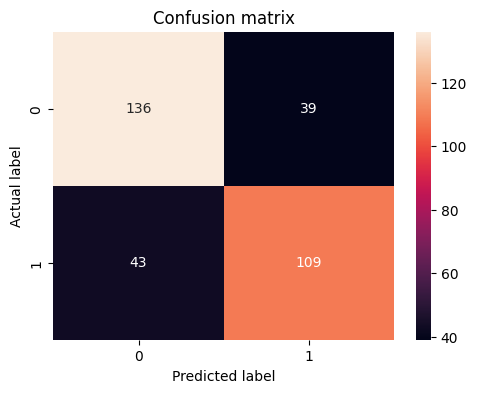

In [ ]:
X_test_u_confident = X_test_u[(X_test_u["prediction_proba"] < cutoff_accuracy) | (X_test_u["prediction_proba"] > (1-cutoff_accuracy))]
X_test_u_confident["prediction"] =  round(X_test_u_confident["prediction_proba"])

cm = metrics.confusion_matrix(X_test_u_confident["prediction"], X_test_u_confident["actual"])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True, fmt="g")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [81]:
X_trial = X
X_trial["year"] = scores["schedule_season"]
X_test_trial = X_trial[X_trial["year"] >= 2021]
X_train_trial = X_trial[X_trial["year"] < 2021]

X_test_trial.drop(columns = ["year"], inplace = True)
X_train_trial.drop(columns = ["year"], inplace = True)



y_train_trial = y[0:X_train_trial.shape[0]]
y_test_trial = y[X_train_trial.shape[0]:]
y_test_trial

<ipython-input-81-985773da7b4e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_trial.drop(columns = ["year"], inplace = True)
<ipython-input-81-985773da7b4e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_trial.drop(columns = ["year"], inplace = True)


,cover
5075,0
5076,0
5077,0
5078,1
5079,0
...,...
5924,0
5925,1
5926,0
5927,0


In [82]:
results = {}
for model, n in models:
   kfold = model_selection.KFold(n_splits=10)
   cv =  model_selection.cross_val_score(model, X_train_trial, y_train_trial, cv = kfold, scoring = "accuracy")
   results.update({n: cv.mean()})

results

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'Logistic Regression': 0.6514268741555236,
 'SVM': 0.6480780878721522,
 'MLP': 0.6533946015623786,
 'Random Forest': 0.604923977698054}

In [83]:
prediction_df = pd.DataFrame()
for model, n in models:
  model.fit(X_train_trial, y_train_trial)
  prediction_df[n] = model.predict(X_test_trial)
  prediction_df[n + "_proba"] = model.predict_proba(X_test_trial)[:,1]


prediction_df["actual"] = y_test.reset_index(drop=True)

prediction_df["cover_prediction"] = prediction_df[["Logistic Regression", "SVM", "MLP", "Random Forest"]].mean(axis=1)

prediction_df["cover_prediction_proba"] = prediction_df[["Logistic Regression_proba", "SVM_proba", "MLP_proba", "Random Forest_proba"]].mean(axis=1)
prediction_df

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Logistic Regression,Logistic Regression_proba,SVM,SVM_proba,MLP,MLP_proba,Random Forest,Random Forest_proba,actual,cover_prediction,cover_prediction_proba
0,0,0.353544,0,0.463494,0,0.323462,1,0.507510,0,0.25,0.412002
1,0,0.160317,0,0.162128,0,0.144978,0,0.283330,1,0.00,0.187688
2,1,0.817067,1,0.840061,1,0.822462,1,0.605275,1,1.00,0.771216
3,1,0.551107,1,0.500000,1,0.542812,0,0.459022,1,0.75,0.513235
4,0,0.248714,0,0.343578,0,0.225883,0,0.364170,0,0.00,0.295586
...,...,...,...,...,...,...,...,...,...,...,...
849,1,0.569649,1,0.593739,1,0.561956,1,0.522966,1,1.00,0.562078
850,0,0.354477,0,0.300300,0,0.335541,0,0.479685,0,0.00,0.367501
851,1,0.613183,1,0.614288,1,0.608293,1,0.514290,1,1.00,0.587514
852,1,0.509756,1,0.617104,0,0.497586,1,0.540531,0,0.75,0.541244


In [85]:
X_test_trial = X_test_trial.reset_index()

X_test_trial["prediction"] = prediction_df["cover_prediction_proba"]
X_test_trial["prediction_proba"] = prediction_df["cover_prediction_proba"]
X_test_trial["actual"] = y_test_trial.reset_index(drop = True)


total_rows = X_test_trial.shape[0]

X_test_trial_confident = X_test_trial[(X_test_trial["prediction_proba"] < cutoff_accuracy) | (X_test_trial["prediction_proba"] > (1-cutoff_accuracy))]
X_test_trial_confident["prediction"] =  round(X_test_trial_confident["prediction_proba"])

confident_rows = X_test_trial_confident.shape[0]

conf_rate = confident_rows / total_rows
conf_rate



<ipython-input-85-5735e9144cb2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_trial_confident["prediction"] =  round(X_test_trial_confident["prediction_proba"])


0.20725995316159251

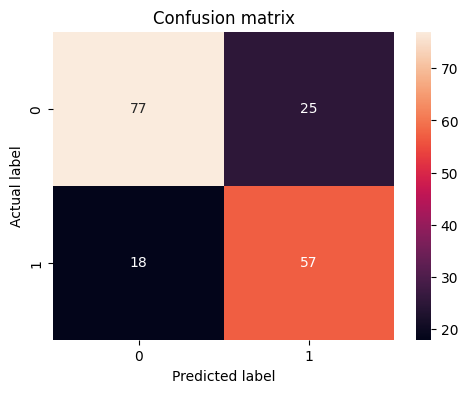

In [86]:
cm = metrics.confusion_matrix(X_test_trial_confident["prediction"], X_test_trial_confident["actual"])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True, fmt="g")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

<ipython-input-158-a547c818f0da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_trial_confident["schedule_season"] = scores["schedule_season"]
<ipython-input-158-a547c818f0da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_trial_confident["schedule_week"] = scores["schedule_week"]
<ipython-input-158-a547c818f0da>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

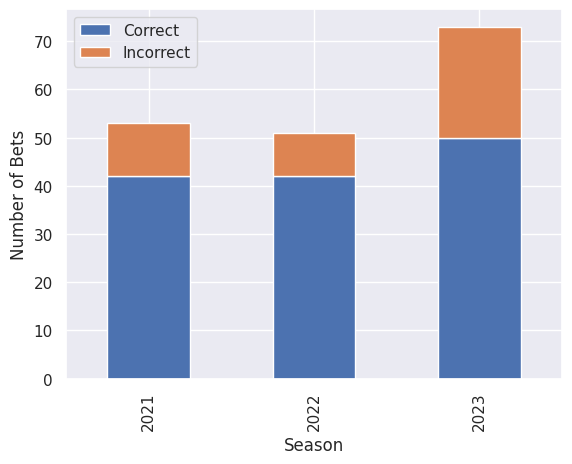

In [158]:
X_test_trial_confident.index = X_test_trial_confident["index"]

X_test_trial_confident["schedule_season"] = scores["schedule_season"]
X_test_trial_confident["schedule_week"] = scores["schedule_week"]

X_test_trial_confident["correct"] = np.where(X_test_trial_confident["prediction"] == X_test_trial_confident["actual"], 1, 0)

money = X_test_trial_confident.groupby(["schedule_season", "schedule_week"]).sum()[["correct"]]

money["bets"] = X_test_trial_confident.groupby(["schedule_season", "schedule_week"]).count()["index"]

money["incorrect"] = money["bets"] - money["correct"]

money["success_rate"] = money["correct"] / money["bets"]

money["net_units"] = money["correct"] - (money["incorrect"])

money_years = money.groupby("schedule_season").sum()

ax = money_years[["correct", "incorrect"]].plot( kind = "bar", stacked = True)
ax.set_xlabel("Season")
ax.set_ylabel("Number of Bets")
ax.legend(["Correct", "Incorrect"])

In [159]:
money = money.reset_index()


In [170]:
money["schedule_week"] = money["schedule_week"].astype(int)
money["schedule_season"] = money["schedule_season"].astype(int)
money["net_profit"] = money["net_units"] * 10
money[["schedule_season", "schedule_week", "bets", "success_rate", "net_profit"]].sort_values(by = ["schedule_season", "schedule_week"]).reset_index()

,index,schedule_season,schedule_week,bets,success_rate,net_profit
0,0,2021,1,5,0.600000,10
1,9,2021,2,5,1.000000,50
2,10,2021,3,2,1.000000,20
3,11,2021,4,3,0.666667,10
4,12,2021,5,4,0.750000,20
5,13,2021,6,1,1.000000,10
6,14,2021,7,6,0.500000,0
7,15,2021,8,4,0.750000,20
8,16,2021,9,2,1.000000,20
9,1,2021,10,4,1.000000,40


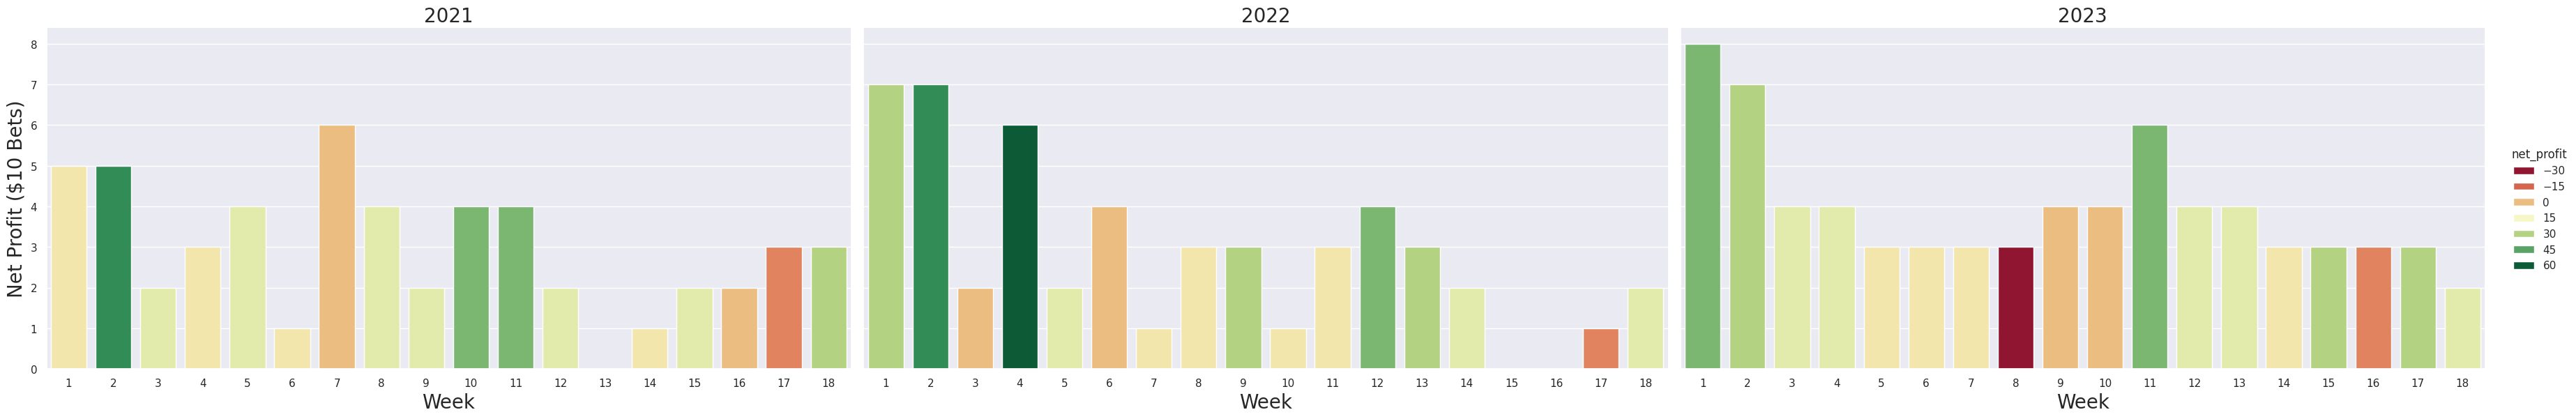

In [197]:
money["net_profit"] = money["net_profit"].astype(float)
cat = sns.catplot(
    money, kind="bar",
    x="schedule_week", y="bets", col="schedule_season",
    height=6, aspect=2, hue = "net_profit", palette = "RdYlGn",  dodge=False)

cat.set_axis_labels("Week", "Net Profit ($10 Bets)", fontsize = 20)
cat.set_titles("{col_name}", size = 20)


In [153]:
money_years

,correct,bets,incorrect,success_rate,net_units
schedule_season,,,,,
2021,42,53,11,14.100000,31
2022,42,51,9,12.904762,33
2023,50,73,23,12.797619,27


In [154]:


print(f"Total success rate from 2021-2023 is {round(money['success_rate'].mean()*100, 2)} %")
print(f"Total net wins from 2021-2023 is {round(money['net_units'].sum(), 2) }")

Total success rate from 2021-2023 is 76.54 %
Total net wins from 2021-2023 is 91
